##  EDA for Predicting Activity in Elderly Living Spaces




###  Objective

We aim to support ElderGuard Analytics in building a **non-invasive early warning system** for elderly individuals living independently. 

### Target Variable

The key variable of interest (target variable) is **`Activity Level`**, which classifies a resident’s behavior as:

- `low_activity`
- `moderate_activity`
- `high_activity`

###  Purpose of this Exploratory Data Analysis (EDA)

- Understand the structure and quality of the data
- Detect missing values, inconsistencies, and outliers
- Visualize relationships between features and the target variable
- Identify strong predictors for use in modeling

### Overview

 1. Environment set-up
 2. Data preview
 3. Categorical data cleaning and encodding
 4. Numerical data cleaning
 5. Outlier detection and treatment
 6. Uni-variate analysis
 7. Bi-variate analysis
 8. Correlation and insights




---


1a. Importing the necessary libraries for data exploration and visualization. This notebook environment is now set up and optimised for EDA.

In [1869]:
import sqlite3
import pandas as pd
import numpy as np  
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')
%matplotlib inline

1b. Establishing a connection to the SQLite database and creating a cursor for executing SQL queries.

In [1870]:
conn = sqlite3.connect('data/gas_monitoring.db')
cursor = conn.cursor()


---

2a. We can now extract the dataset into a pandas DataFrame and preview the first 5 rows from the `gas_monitoring` table. This will help us ensure it has been loaded properly before diving deeper. We will also print out the number of columns and rows to get a gauge of the sample size.

In [1871]:
df = pd.read_sql_query("SELECT * FROM gas_monitoring", conn)
df.head(5)


,Time of Day,Temperature,Humidity,CO2_InfraredSensor,CO2_ElectroChemicalSensor,MetalOxideSensor_Unit1,MetalOxideSensor_Unit2,MetalOxideSensor_Unit3,MetalOxideSensor_Unit4,CO_GasSensor,Session ID,HVAC Operation Mode,Ambient Light Level,Activity Level
0,morning,19.63,53.83,125.49,571.09,478.55,735.85,497.59,565.05,medium,7241,off,very_dim,Low Activity
1,morning,19.66,53.69,126.34,575.79,491.96,740.28,NaN,557.08,low,7241,ventilation_only,bright,Low Activity
2,night,20.95,54.12,119.34,556.53,437.50,718.34,NaN,612.62,medium,9385,off,None,Low Activity
3,morning,20.10,50.48,113.50,NaN,515.14,744.02,676.15,600.22,low,7241,eco_mode,very_bright,High Activity
4,morning,19.89,48.42,92.77,613.65,535.66,770.27,720.27,625.73,low,7241,Heating_active,moderate,Low Activity


In [1872]:
df.shape

(10000, 14)

The table has 10 000 rows and 14 columns.

2b. Let's find out about the types of data we are dealing with, check for columns with missing values, as well as duplicated rows

### Data types

In [1873]:
df.dtypes
#check for data types


Time of Day                   object
Temperature                  float64
Humidity                     float64
CO2_InfraredSensor           float64
CO2_ElectroChemicalSensor    float64
MetalOxideSensor_Unit1       float64
MetalOxideSensor_Unit2       float64
MetalOxideSensor_Unit3       float64
MetalOxideSensor_Unit4       float64
CO_GasSensor                  object
Session ID                     int64
HVAC Operation Mode           object
Ambient Light Level           object
Activity Level                object
dtype: object

We can see that 9 of the columns take in numerical data, while the remaining 5 (including our target variable) take in categorical data.

### Duplicates

In [1874]:
print("Total duplicate rows:", df.duplicated().sum())
#check number of duplicate rows


Total duplicate rows: 120


In [1875]:
dup = df[df.duplicated(keep=False)].sort_values(by=list(df.columns))
dup.head(6)
#preview and inspect the first few duplicates

,Time of Day,Temperature,Humidity,CO2_InfraredSensor,CO2_ElectroChemicalSensor,MetalOxideSensor_Unit1,MetalOxideSensor_Unit2,MetalOxideSensor_Unit3,MetalOxideSensor_Unit4,CO_GasSensor,Session ID,HVAC Operation Mode,Ambient Light Level,Activity Level
685,afternoon,16.86,46.12,85.16,590.81,436.11,739.87,705.77,634.27,low,2679,cooling_active,bright,Moderate Activity
4066,afternoon,16.86,46.12,85.16,590.81,436.11,739.87,705.77,634.27,low,2679,cooling_active,bright,Moderate Activity
1827,afternoon,17.33,47.63,82.59,613.07,438.34,757.98,725.52,649.64,extremely low,3418,cooling_active,very_bright,Moderate Activity
3487,afternoon,17.33,47.63,82.59,613.07,438.34,757.98,725.52,649.64,extremely low,3418,cooling_active,very_bright,Moderate Activity
1770,afternoon,18.12,48.85,93.17,612.03,489.97,761.61,NaN,655.67,extremely low,2105,off,very_bright,Low Activity
3793,afternoon,18.12,48.85,93.17,612.03,489.97,761.61,NaN,655.67,extremely low,2105,off,very_bright,Low Activity


We can see that these duplicates are indeed exact copies of each other, sharing the same session ID. There’s no timestamp column to differentiate these duplicates, and they are likely from repeated session logging rather than distinct events. Since they add no new information, we can safely drop them.

In [1876]:
df.drop_duplicates(inplace=True)
#removing duplicate rows


In [1877]:
print("Total duplicate rows:", df.duplicated().sum())

Total duplicate rows: 0


### Missingness

In [1878]:
missing_summary = df.isnull().sum()[df.isnull().sum() > 0].to_frame(name='Missing inputs')
missing_summary['%'] = ((missing_summary['Missing inputs'] / len(df)) * 100).round(1)
missing_summary.sort_values(by='%', ascending=False, inplace=True)
print(missing_summary)
#check for missing values



                           Missing inputs     %
MetalOxideSensor_Unit3               2554  25.9
Ambient Light Level                  2519  25.5
CO_GasSensor                         1365  13.8
CO2_ElectroChemicalSensor             705   7.1


These incomplete columns have missingness ranging from mild (~7%) to moderate (~14%) and significant (~26%). We will need to handle these missingness accordingly in part 3.

2c. For the columns taking in `numerical data`, we can have a statistical summary of their values.

In [1879]:
df.describe().round(2)

,Temperature,Humidity,CO2_InfraredSensor,CO2_ElectroChemicalSensor,MetalOxideSensor_Unit1,MetalOxideSensor_Unit2,MetalOxideSensor_Unit3,MetalOxideSensor_Unit4,Session ID
count,9880.00,9880.00,9880.00,9175.00,9880.00,9880.00,7326.00,9880.00,9880.00
mean,42.80,51.12,110.33,578.37,470.45,728.33,681.47,612.05,5416.23
std,74.72,20.69,25.13,22.67,51.38,43.45,60.24,42.88,2586.36
min,14.94,-49.66,-14.67,408.60,286.83,554.28,457.81,412.79,1374.00
25%,18.99,47.66,99.03,559.28,439.72,707.97,658.40,585.64,3074.00
50%,20.53,51.28,113.06,578.93,468.84,726.71,680.19,609.13,5214.00
75%,23.13,53.85,124.02,595.26,493.98,746.57,704.50,635.57,7395.00
max,298.93,199.59,236.01,637.90,632.89,902.21,905.15,736.11,9658.00


We observe that:

- Max value for temperature looks unrealistic.
- Both Min and Max value of humidity lie outside of the valid range (0-100%)
- Min value for CO2 infrared sensor is negative.
 
This indicates the need for outlier filtering or value clipping (which we will perform later) before modeling.

### Heatmap
We can plot a heatmap to check correlations between numerical features.

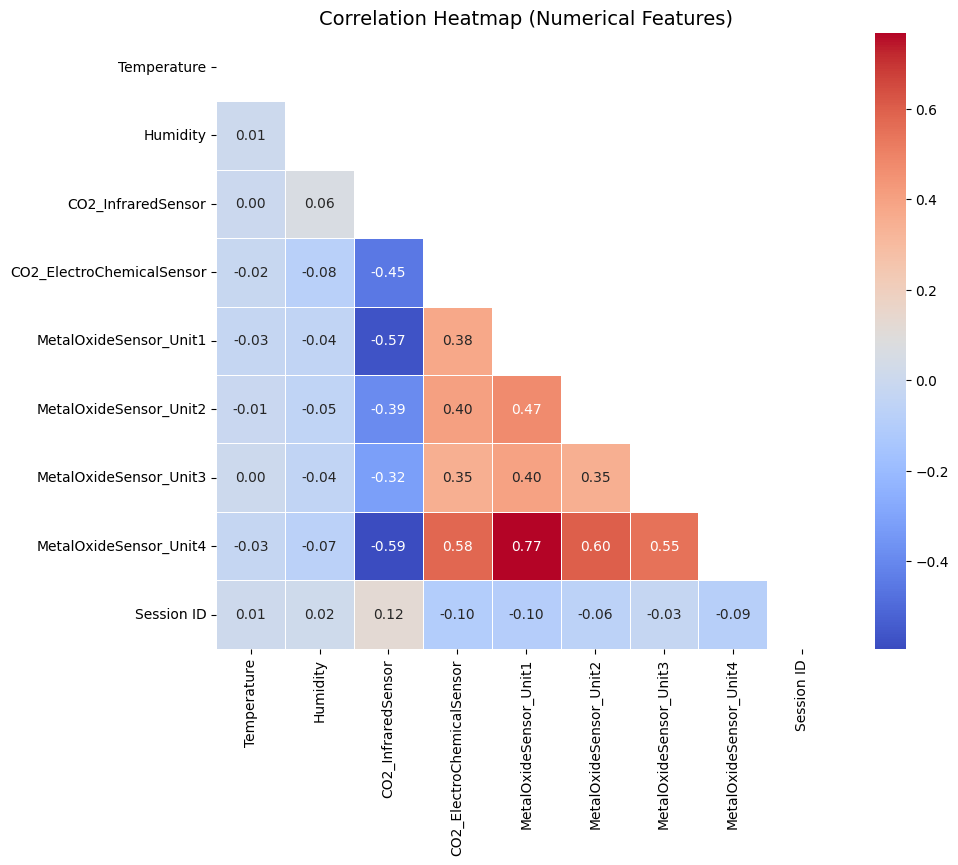

In [1880]:
numeric_df = df.select_dtypes(include=['float64', 'int64'])

corr_matrix = numeric_df.corr()
mask = np.triu(np.ones_like(corr_matrix, dtype=bool))

plt.figure(figsize=(10, 8))
sns.heatmap(corr_matrix,
            mask=mask,
            annot=True,
            cmap="coolwarm",
            fmt=".2f",
            linewidths=0.5)      
plt.title("Correlation Heatmap (Numerical Features)", fontsize=14)
plt.show()

Strong positive correlations:

- MetalOxideSensor_Unit4 and MetalOxide_Unit1 (0.77)
- MetalOxideSensor_Unit4 and MetalOxideSensor_Unit2 (0.60)
- CO2_ElectroChemicalSensor and MetalOxideSensor_Unit4 (0.58)

Strong negative correlations:

- CO2_InfraredSensor and MetalOxideSensor_Unit1 (-0.57)
- CO2_InfraredSensor and MetalOxideSensor_Unit4 (-0.59)

We can conclude that some features may be redundant due to multicollinearity. These correlations will be useful in helping us decide our method for imputation. 

2d. For the columns taking in `categorical` data, we can print out the unique inputs of each columns respectively. This will allow us to standardise inconsistent data, convert ordinal categories to numerical values if meaningful, and prepare the values for modeling.

#### Standardising categorical data inputs

In [1881]:
df['Activity Level'] = df['Activity Level'].str.lower().str.strip()

act_map ={
    
    'low activity': 'low_activity',
    'low_activity': 'low_activity',
    'lowactivity' : 'low_activity',
    'high activity' : 'high_activity',
    'moderate activity' : 'moderate_activity',
    'moderateactivity' : 'moderate_activity'
}

df['Activity Level'] = df['Activity Level'].replace(act_map)

In [1882]:
df['HVAC Operation Mode'] = df['HVAC Operation Mode'].str.lower().str.strip()

hvac_map ={
    
    'eco_mode': 'eco_mode',
    'eco mode': 'eco_mode',
    'eco': 'eco_mode',
    'heating_active': 'heating',
    'heating': 'heating',
    'cooling_active': 'cooling',
    'cooling': 'cooling',
    'ventilation_only': 'ventilation',
    'ventilation': 'ventilation',
    'off': 'off',
    'maintenance_mode': 'maintenance',
    'maintenance': 'maintenance'
}

df['HVAC Operation Mode'] = df['HVAC Operation Mode'].replace(hvac_map)


In [1883]:
print("Time of day:",df['Time of Day'].unique(), "\n")
print("CO_GasSensor:", df['CO_GasSensor'].unique(), "\n")
print("Ambient Light Level:",df['Ambient Light Level'].unique(), "\n")
print("HVAC Operation Mode:",df['HVAC Operation Mode'].unique(), "\n")
print("Activity Level:",df['Activity Level'].unique())

Time of day: ['morning' 'night' 'afternoon' 'evening'] 

CO_GasSensor: ['medium' 'low' 'extremely low' None 'high' 'extremely high'] 

Ambient Light Level: ['very_dim' 'bright' None 'very_bright' 'moderate' 'dim'] 

HVAC Operation Mode: ['off' 'ventilation' 'eco_mode' 'heating' 'maintenance' 'cooling'] 

Activity Level: ['low_activity' 'high_activity' 'moderate_activity']




 --- 

### 3. Numerical features data cleaning

#### Distributions for all numerical features

- For numerical features, we will need to perform outlier treatment. The presence of outliers makes the general representation or summarisation of data become difficult

- Before we do any treatment, we first need to ascertain whether the outlier is a data entry error or it is a genuine value.


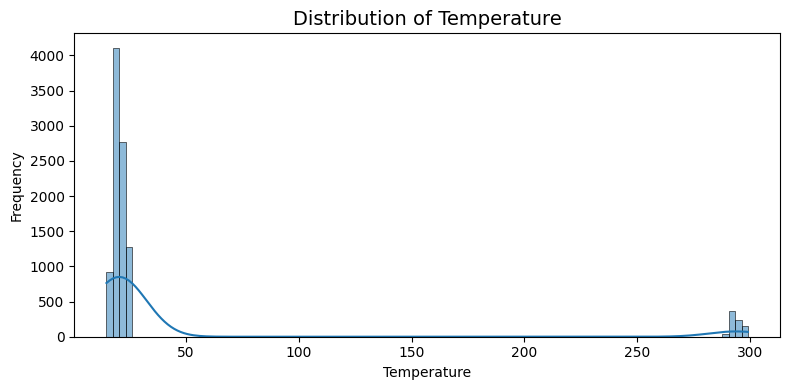

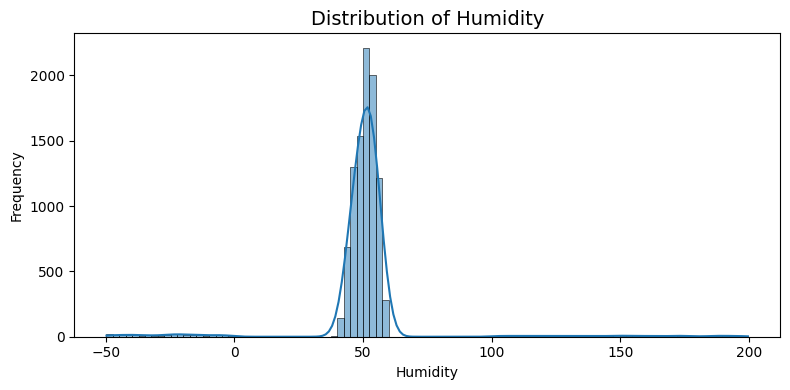

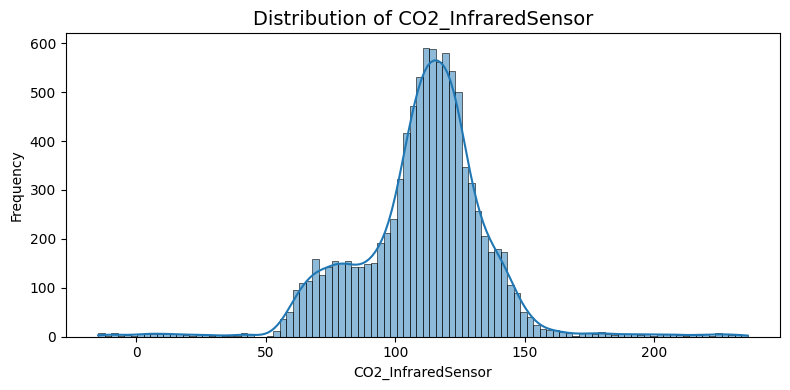

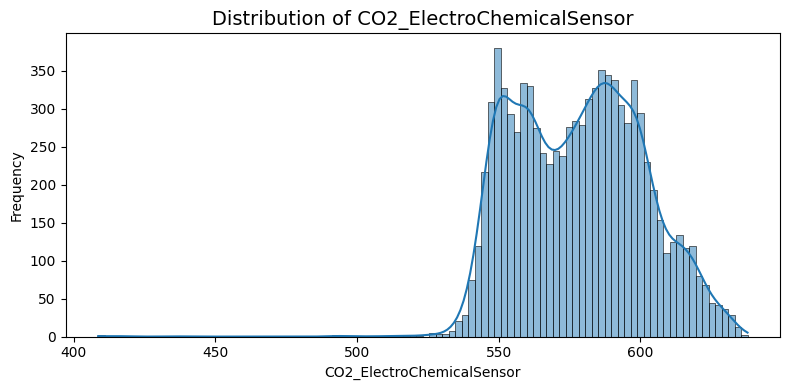

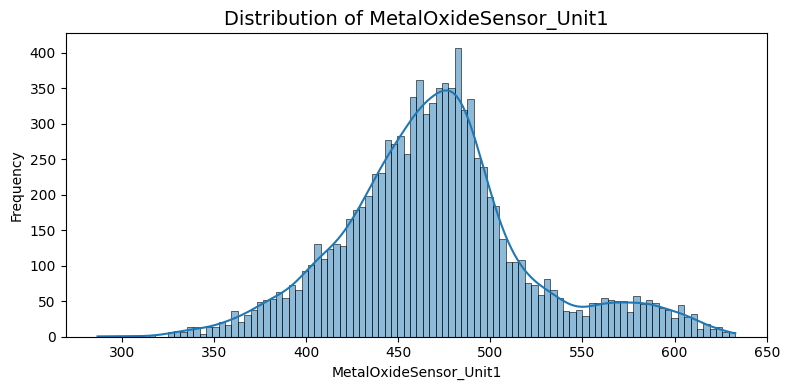

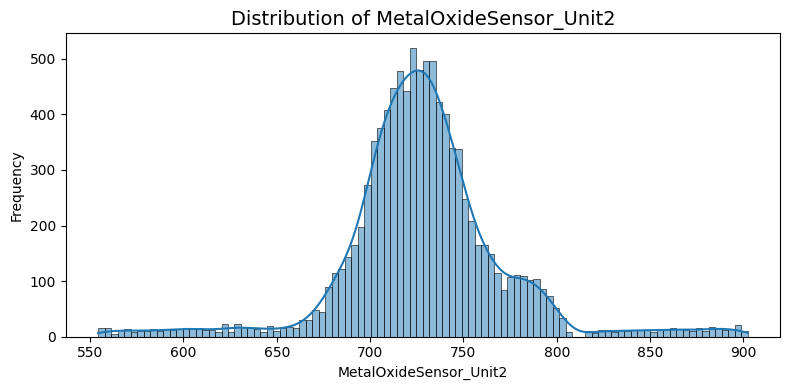

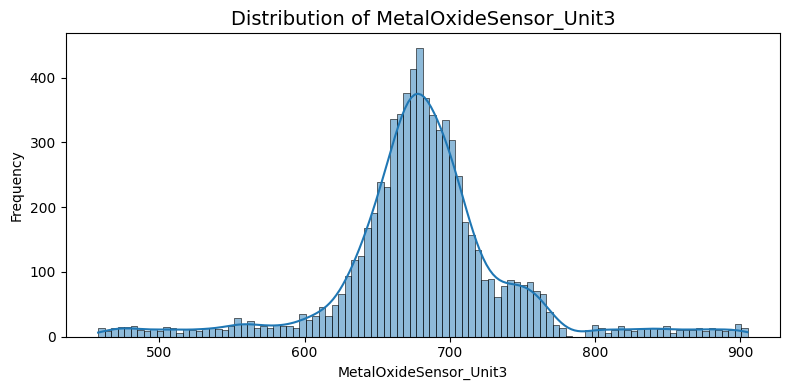

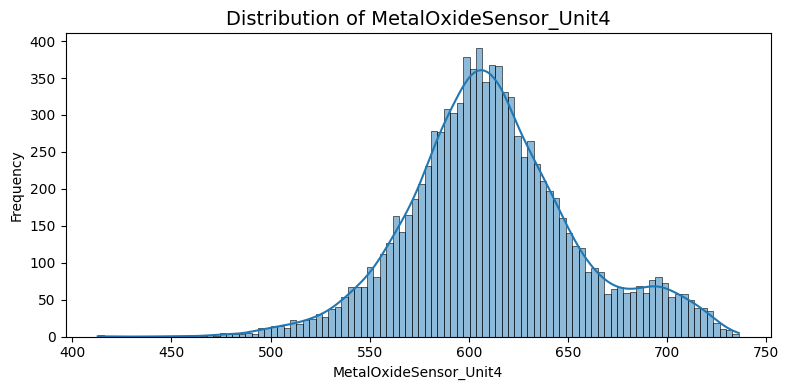

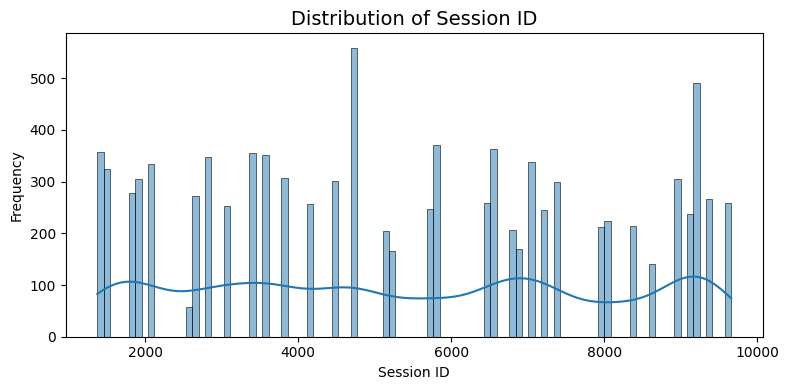

In [1884]:
numeric_cols_for_plot = df.select_dtypes(include=['float64', 'int64']).columns.tolist()
col_to_drop = ['Activity Level', 'CO_GasSensor']
numeric_cols_for_plot = [col for col in numeric_cols_for_plot if col not in col_to_drop]


for col in numeric_cols_for_plot:
    plt.figure(figsize=(8, 4))
    sns.histplot(df[col], kde=True, bins=100)
    plt.title(f"Distribution of {col}", fontsize=14)
    plt.xlabel(col)
    plt.ylabel("Frequency")
    plt.tight_layout()
    plt.show()

#### 3a. 'Session ID' column

We refer to the heatmap in section 2c and observe that this column has very little correlation with other numerical features. It is also likely just a label that doesn't represent sensor reading or occupant's behaviour. In ML models, it would behave like a random number and introduce meaningless variance. As such, we will drop this column.


In [1885]:
df.drop(columns=['Session ID'], inplace=True)

In [1886]:
df.head(3)

,Time of Day,Temperature,Humidity,CO2_InfraredSensor,CO2_ElectroChemicalSensor,MetalOxideSensor_Unit1,MetalOxideSensor_Unit2,MetalOxideSensor_Unit3,MetalOxideSensor_Unit4,CO_GasSensor,HVAC Operation Mode,Ambient Light Level,Activity Level
0,morning,19.63,53.83,125.49,571.09,478.55,735.85,497.59,565.05,medium,off,very_dim,low_activity
1,morning,19.66,53.69,126.34,575.79,491.96,740.28,NaN,557.08,low,ventilation,bright,low_activity
2,night,20.95,54.12,119.34,556.53,437.50,718.34,NaN,612.62,medium,off,None,low_activity


#### 3b. 'Temperature' Column

In [1887]:
column_to_analyze = 'Temperature'
df[column_to_analyze] = pd.to_numeric(df[column_to_analyze], errors='coerce')

Q1 = df[column_to_analyze].quantile(0.25)
Q2 = df[column_to_analyze].quantile(0.5)
Q3 = df[column_to_analyze].quantile(0.75)

IQR = Q3 - Q1 
lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR

lower_outliers = df[df[column_to_analyze] < lower_bound]
upper_outliers = df[df[column_to_analyze] > upper_bound]

print(f"Total outliers: {(lower_outliers.shape[0] + upper_outliers.shape[0])}")
print(f"Outliers below lower bound: {lower_outliers.shape[0]}")
print(f"Outliers above upper bound: {upper_outliers.shape[0]}")

Total outliers: 804
Outliers below lower bound: 0
Outliers above upper bound: 804


We have 804 outliers. Too significant to be removed.

Looking at temperature’s distribution from our earlier histogram, the distribution has a few extreme tails (likely sensor glitches). In environmental sensor data, such extremes are usually measurement noise rather than true rare events. We shall do an initial clipping of outliers to 40 degrees celcius before exploring the relationship between temperature, time of day and HVAC operation mode with a box-and-whisker graph.

In [1888]:
df['Temperature'] = df['Temperature'].clip(upper=40)

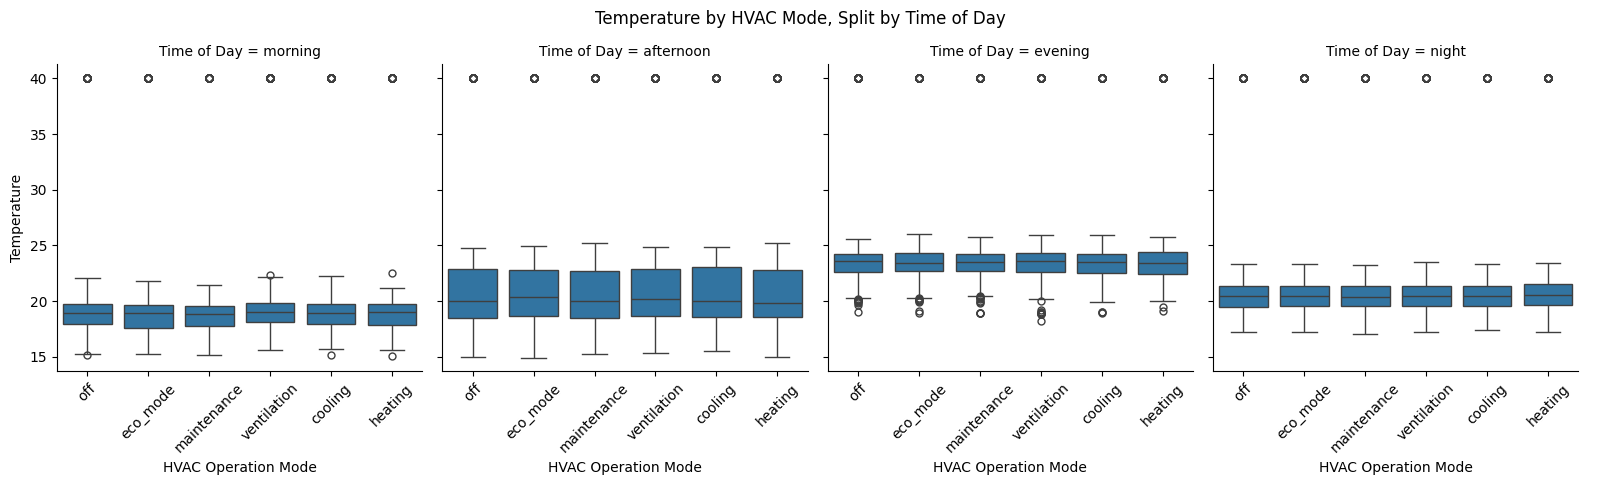

In [1889]:
g = sns.catplot(
    data=df,
    x='HVAC Operation Mode',
    y='Temperature',
    col='Time of Day',
    kind='box',
    order=['off', 'eco_mode', 'maintenance', 'ventilation', 'cooling', 'heating'],
    col_order=['morning', 'afternoon', 'evening', 'night'],
    height=4,
    aspect=1
)
g.set_xticklabels(rotation=45)
g.fig.suptitle("Temperature by HVAC Mode, Split by Time of Day", y=1.05)
plt.show()

We observe that within each day, the median temperature across HVAC modes is fairly close. The biggest changes in temperature are between times of day, and not HVAC modes. This suggest that time of day is the stronger driver of temperature changes. Hence, we will deal with the outliers using an interquatile range-based clipping, first on the global dataset, then according to Time of Day but applied separately for each time of day.

In [1890]:
# Function for IQR-based clipping
def cap_outliers(series, factor=1.5):
    Q1 = series.quantile(0.25)
    Q3 = series.quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - factor * IQR
    upper_bound = Q3 + factor * IQR
    return series.clip(lower_bound, upper_bound)

#df['Temperature'] = cap_outliers(df['Temperature'])

# Apply IQR clipping to Temperature within each Time of Day group
df['Temperature'] = df.groupby('Time of Day')['Temperature'].transform(lambda x: cap_outliers(x, factor=1.5))

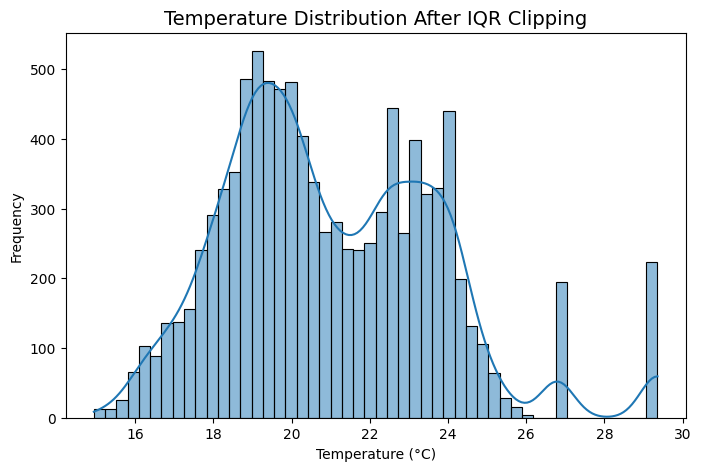

In [1891]:
plt.figure(figsize=(8, 5))
sns.histplot(df['Temperature'], bins=50, kde=True)  # kde=True adds a smooth curve
plt.title("Temperature Distribution After IQR Clipping", fontsize=14)
plt.xlabel("Temperature (°C)")
plt.ylabel("Frequency")
plt.show()

The overall range (~15-29°C) now makes sense for an indoor environment.

In [1892]:
column_to_analyze = 'Temperature'
df[column_to_analyze] = pd.to_numeric(df[column_to_analyze], errors='coerce')

Q1 = df[column_to_analyze].quantile(0.25)
Q2 = df[column_to_analyze].quantile(0.5)
Q3 = df[column_to_analyze].quantile(0.75)

IQR = Q3 - Q1 
lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR

lower_outliers = df[df[column_to_analyze] < lower_bound]
upper_outliers = df[df[column_to_analyze] > upper_bound]

print(f"Total outliers: {(lower_outliers.shape[0] + upper_outliers.shape[0])}")
print(f"Outliers below lower bound: {lower_outliers.shape[0]}")
print(f"Outliers above upper bound: {upper_outliers.shape[0]}")

Total outliers: 224
Outliers below lower bound: 0
Outliers above upper bound: 224


#### 3c. 'Humidity' Column

In [1893]:
column_to_analyze = 'Humidity'
df[column_to_analyze] = pd.to_numeric(df[column_to_analyze], errors='coerce')

Q1 = df[column_to_analyze].quantile(0.25)
Q2 = df[column_to_analyze].quantile(0.5)
Q3 = df[column_to_analyze].quantile(0.75)

IQR = Q3 - Q1 
lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR

lower_outliers = df[df[column_to_analyze] < lower_bound]
upper_outliers = df[df[column_to_analyze] > upper_bound]

print(f"Total outliers: {(lower_outliers.shape[0] + upper_outliers.shape[0])}")
print(f"Outliers below lower bound: {lower_outliers.shape[0]}")
print(f"Outliers above upper bound: {upper_outliers.shape[0]}")

Total outliers: 503
Outliers below lower bound: 269
Outliers above upper bound: 234


Looking at the Humidity distribution, most readings cluster tightly around 50%.We also have extreme unrealistic values:
- Negative humidity (physically impossible)
- Very high humidity (>100%), which also doesn’t make sense

This is likely sensor error or data entry issues rather than real variation.

Let's explore the relationship between humidity and other environmental features (Time of day, HVAC Operation Mode, Temperature) using scatterplot and box-and-whisker graph

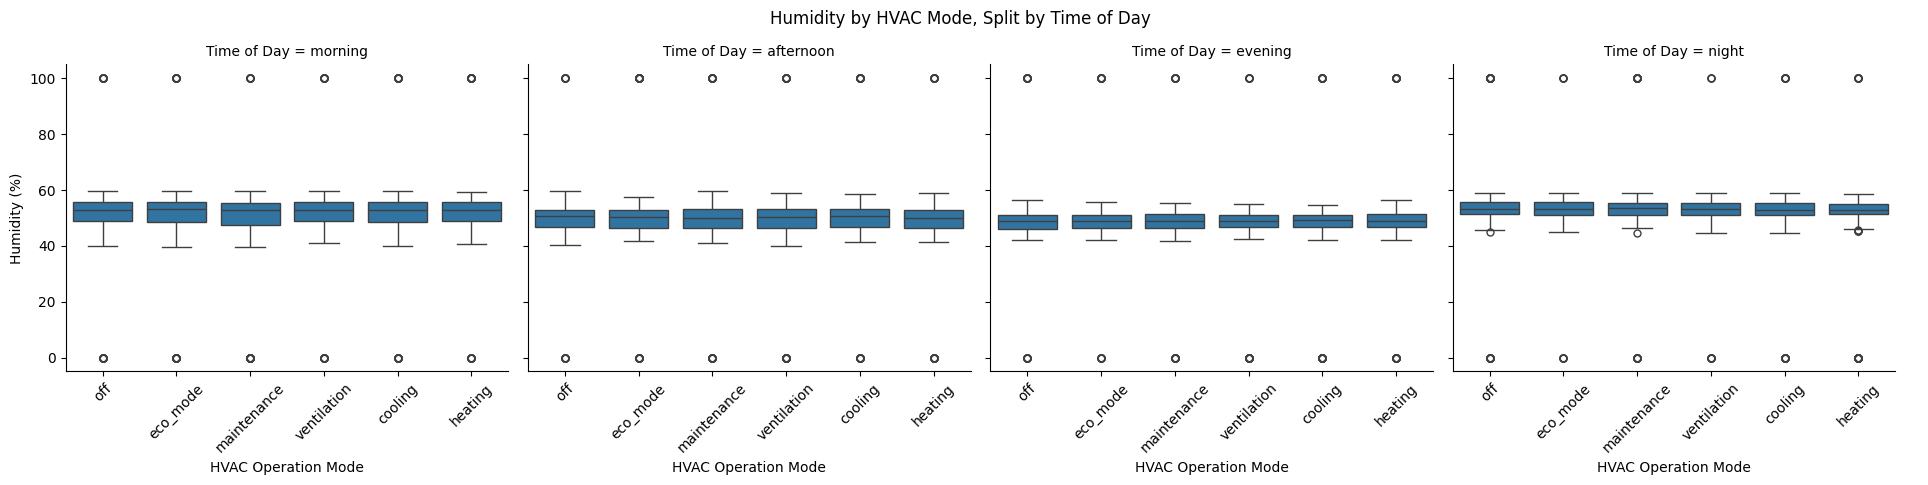

In [1894]:
df['Humidity'] = df['Humidity'].clip(lower=0, upper=100) #temporary clipping for the sake of viewing on graph


g = sns.catplot(
    data=df,
    x='HVAC Operation Mode',
    y='Humidity',
    col='Time of Day',
    kind='box',
    order=['off', 'eco_mode', 'maintenance', 'ventilation', 'cooling', 'heating'],
    col_order=['morning', 'afternoon', 'evening', 'night'],
    height=4,
    aspect=1.2
)
g.set_xticklabels(rotation=45)
g.set_axis_labels("HVAC Operation Mode", "Humidity (%)")
g.fig.suptitle("Humidity by HVAC Mode, Split by Time of Day", y=1.05)
plt.show()

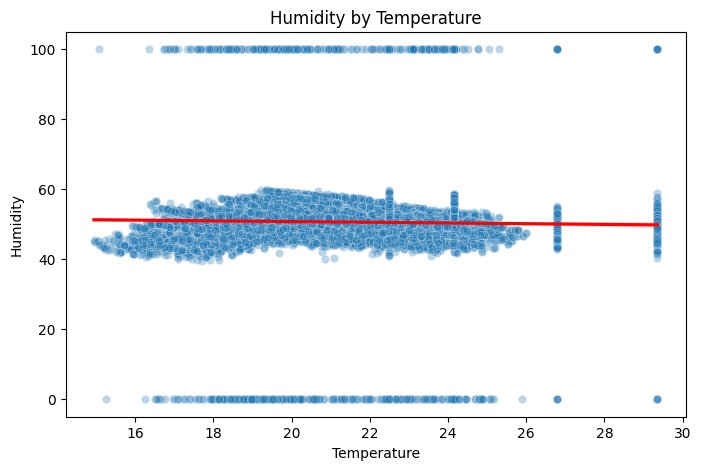

In [1895]:
plt.figure(figsize=(8,5))
sns.scatterplot(data=df, x='Temperature', y='Humidity', alpha=0.3)
sns.regplot(data=df, x='Temperature', y='Humidity', scatter=False, color='red')
plt.title("Humidity by Temperature")
plt.show()

There's no strong linear relationship between humidity and temperature based on the scatterplot graph. HVAC mode does not strongly affect humidity levels. Across all times of day, humidity medians vary a little.

We will be doing IQR clipping twice

1. First clipping: Treat all humidity readings as one big dataset, regardless of when they were recorded. Compute Q1, Q3, IQR for the entire dataset before clipping anything outside that global range

2. Second clipping: Split the data into separate groups by Time of Day (morning, afternoon, evening, night). Compute Q1, Q3, IQR within each group. Clip outliers relative to that group’s normal range

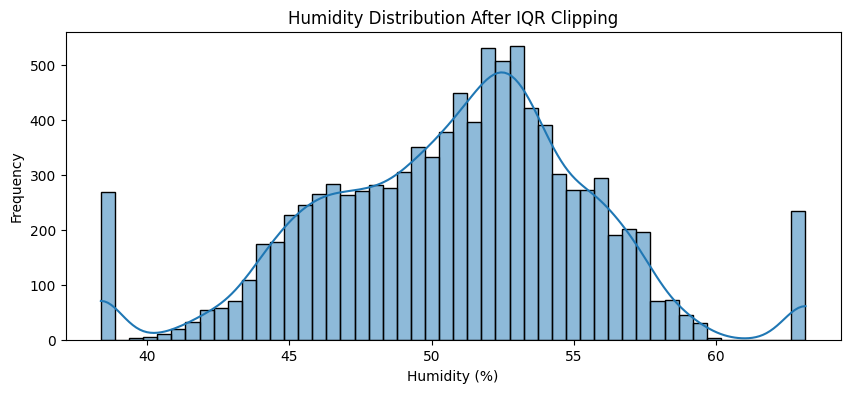

In [1896]:
# IQR capping function
def cap_outliers(series, factor=1.5):
    Q1 = series.quantile(0.25)
    Q3 = series.quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - factor * IQR
    upper_bound = Q3 + factor * IQR
    return series.clip(lower_bound, upper_bound)

# First pass: global
df['Humidity'] = cap_outliers(df['Humidity'])

# Second pass: per time of day
#df['Humidity'] = df.groupby('Time of Day')['Humidity'].transform(cap_outliers)

plt.figure(figsize=(10, 4))
sns.histplot(df['Humidity'], bins=50, kde=True)
plt.title("Humidity Distribution After IQR Clipping")
plt.xlabel("Humidity (%)")
plt.ylabel("Frequency")
plt.show()

In [1897]:
column_to_analyze = 'Humidity'
df[column_to_analyze] = pd.to_numeric(df[column_to_analyze], errors='coerce')

Q1 = df[column_to_analyze].quantile(0.25)
Q2 = df[column_to_analyze].quantile(0.5)
Q3 = df[column_to_analyze].quantile(0.75)

IQR = Q3 - Q1 
lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR

lower_outliers = df[df[column_to_analyze] < lower_bound]
upper_outliers = df[df[column_to_analyze] > upper_bound]

print(f"Total outliers: {(lower_outliers.shape[0] + upper_outliers.shape[0])}")
print(f"Outliers below lower bound: {lower_outliers.shape[0]}")
print(f"Outliers above upper bound: {upper_outliers.shape[0]}")

Total outliers: 0
Outliers below lower bound: 0
Outliers above upper bound: 0


#### 3d. 'CO2_InfraredSensor' column

In [1898]:
column_to_analyze = 'CO2_InfraredSensor'
df[column_to_analyze] = pd.to_numeric(df[column_to_analyze], errors='coerce')

Q1 = df[column_to_analyze].quantile(0.25)
Q2 = df[column_to_analyze].quantile(0.5)
Q3 = df[column_to_analyze].quantile(0.75)

IQR = Q3 - Q1 
lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR

lower_outliers = df[df[column_to_analyze] < lower_bound]
upper_outliers = df[df[column_to_analyze] > upper_bound]

print(f"Total outliers: {(lower_outliers.shape[0] + upper_outliers.shape[0])}")
print(f"Outliers below lower bound: {lower_outliers.shape[0]}")
print(f"Outliers above upper bound: {upper_outliers.shape[0]}")

Total outliers: 384
Outliers below lower bound: 235
Outliers above upper bound: 149


We refer to the heatmap in section 2c and observe CO2_InfraredSensor values are negatively correlated to that of MetalOxideSensor_Unit1 (-0.57) and MetalOxideSensor_Unit4 (-0.59). 

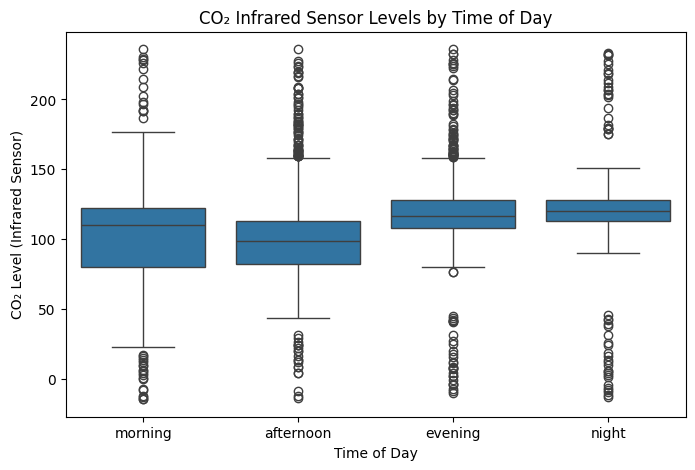

In [1899]:
plt.figure(figsize=(8,5))
sns.boxplot(
    data=df,
    x='Time of Day',
    y='CO2_InfraredSensor',
    order=['morning', 'afternoon', 'evening', 'night']
)
plt.title("CO₂ Infrared Sensor Levels by Time of Day")
plt.xlabel("Time of Day")
plt.ylabel("CO₂ Level (Infrared Sensor)")
plt.show()

The values below zero are not scientifically possible. As such, I will transform them into their absolute value as there may be some systematic glitch or human error when recording the data, leading to the negative sign being added. In addition, it is also very unlikely that the values are zero so clipping to zero would not make sense. We are also not going to do IQR clipping because the data in the heatmap in 2c seems to suggest a negative correlation with MetalOxideSensor_Unit1 (-0.57) and MetalOxideSensor_Unit4 (-0.59). Also, there are clusters of the outliers that are highly dense between certain time of day. This can help the model to infer additional patterns regarding environmental activities.

In [1900]:
df['CO2_InfraredSensor'] = df['CO2_InfraredSensor'].abs()

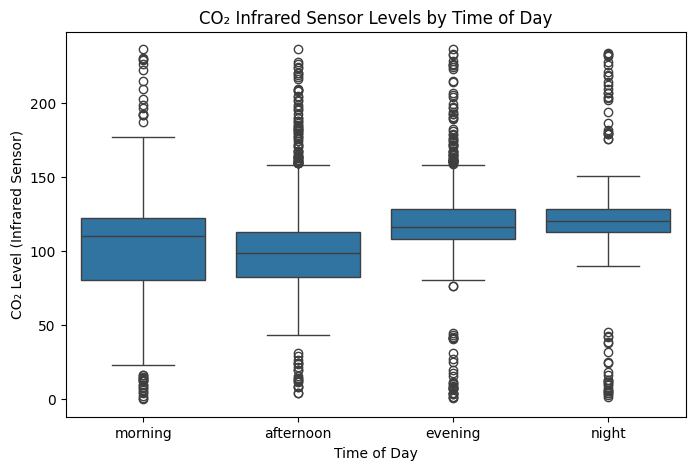

In [1901]:
plt.figure(figsize=(8,5))
sns.boxplot(
    data=df,
    x='Time of Day',
    y='CO2_InfraredSensor',
    order=['morning', 'afternoon', 'evening', 'night']
)
plt.title("CO₂ Infrared Sensor Levels by Time of Day")
plt.xlabel("Time of Day")
plt.ylabel("CO₂ Level (Infrared Sensor)")
plt.show()

#### 3e. 'CO2_ElectroChemicalSensor' column

We know from earlier that there are 705 missing entries in this column (~7% of dataset). 

In [1902]:
column_to_analyze = 'CO2_ElectroChemicalSensor'
df[column_to_analyze] = pd.to_numeric(df[column_to_analyze], errors='coerce')

Q1 = df[column_to_analyze].quantile(0.25)
Q2 = df[column_to_analyze].quantile(0.5)
Q3 = df[column_to_analyze].quantile(0.75)

IQR = Q3 - Q1 
lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR

lower_outliers = df[df[column_to_analyze] < lower_bound]
upper_outliers = df[df[column_to_analyze] > upper_bound]

print(f"Total outliers: {(lower_outliers.shape[0] + upper_outliers.shape[0])}")
print(f"Outliers below lower bound: {lower_outliers.shape[0]}")
print(f"Outliers above upper bound: {upper_outliers.shape[0]}")

Total outliers: 9
Outliers below lower bound: 9
Outliers above upper bound: 0


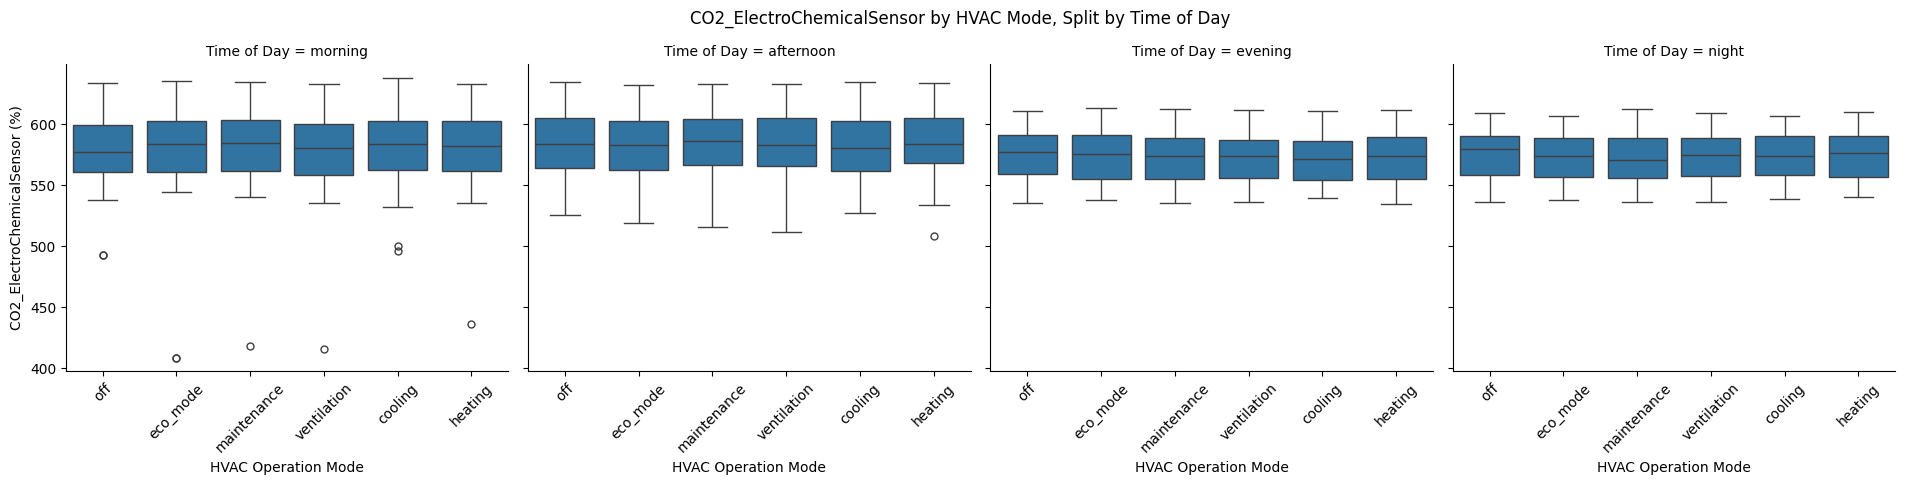

In [1903]:
g = sns.catplot(
    data=df,
    x='HVAC Operation Mode',
    y='CO2_ElectroChemicalSensor',
    col='Time of Day',
    kind='box',
    order=['off', 'eco_mode', 'maintenance', 'ventilation', 'cooling', 'heating'],
    col_order=['morning', 'afternoon', 'evening', 'night'],
    height=4,
    aspect=1.2
)
g.set_xticklabels(rotation=45)
g.set_axis_labels("HVAC Operation Mode", "CO2_ElectroChemicalSensor (%)")
g.fig.suptitle("CO2_ElectroChemicalSensor by HVAC Mode, Split by Time of Day", y=1.05)
plt.show()

Median remains fairly unchanged throughout the day, and in different HVAC Operation Mode.

In [1904]:
col = 'CO2_ElectroChemicalSensor'

Q1 = df[col].quantile(0.25)
Q3 = df[col].quantile(0.75)
IQR = Q3 - Q1
lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR

outliers = df[(df[col] < lower_bound) | (df[col] > upper_bound)]
print(outliers[[col]].to_string(index=True))

      CO2_ElectroChemicalSensor
361                      408.60
3780                     415.72
6330                     492.58
9319                     408.60
9320                     418.15
9321                     436.28
9323                     495.65
9324                     492.58
9325                     500.54


We can conclude that instances of outliers are very rare. We do not have enough data and domain knowledge to infer about these few rows. As such, we will choose to drop them.


In [1905]:
col = 'CO2_ElectroChemicalSensor'

Q1 = df[col].quantile(0.25)
Q3 = df[col].quantile(0.75)
IQR = Q3 - Q1

factor = 1.5
lower_bound = Q1 - factor * IQR
upper_bound = Q3 + factor * IQR

outlier_mask = (df[col] < lower_bound) | (df[col] > upper_bound)
df_no_outliers = df[~outlier_mask].copy()

print(f"Dropped {outlier_mask.sum()} outliers from {col}.")

Dropped 9 outliers from CO2_ElectroChemicalSensor.


#### Linear Regression for imputation

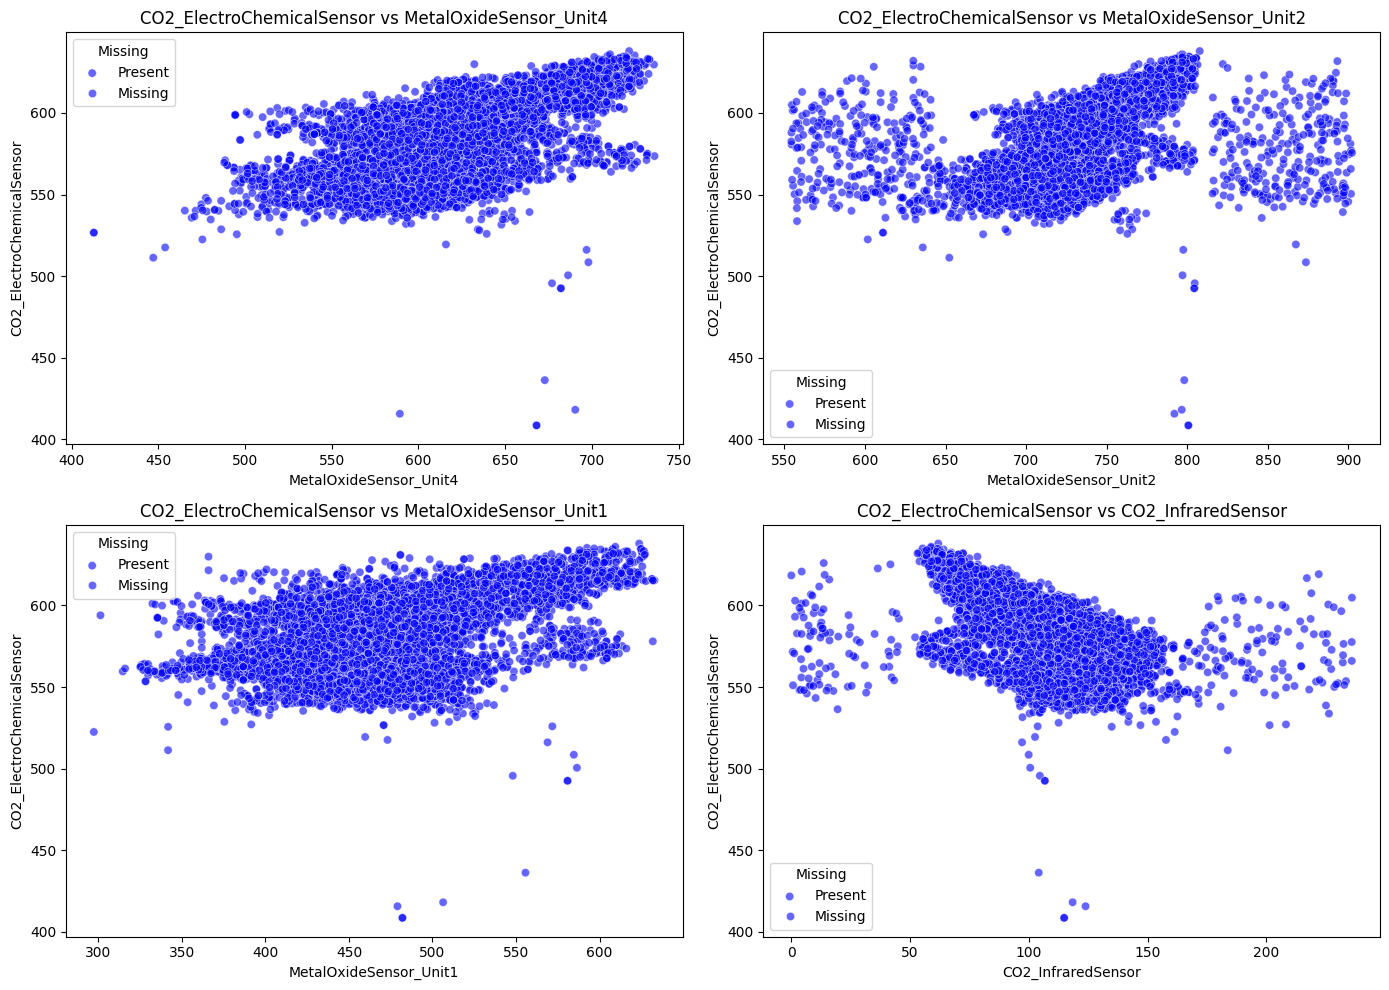

In [1906]:
target = 'CO2_ElectroChemicalSensor'
#based on heatmap in part 2c.
correlated_cols = ['MetalOxideSensor_Unit4', 'MetalOxideSensor_Unit2',
                   'MetalOxideSensor_Unit1', 'CO2_InfraredSensor']

# Mask for missing rows
missing_mask = df[target].isna()


fig, axes = plt.subplots(2, 2, figsize=(14, 10))
axes = axes.flatten()

for i, col in enumerate(correlated_cols):
    sns.scatterplot(
        x=df[col], 
        y=df[target], 
        hue=missing_mask, 
        palette={True: 'red', False: 'blue'}, 
        alpha=0.6, 
        ax=axes[i]
    )
    axes[i].set_title(f"{target} vs {col}")
    axes[i].legend(title="Missing", labels=["Present", "Missing"])

plt.tight_layout()
plt.show()

We can use the correlation to train a Linear Regression model to predict the missing values as this feature exhibits collinearity with other features.


In [1907]:
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score, mean_squared_error

target = 'CO2_ElectroChemicalSensor'
predictors = [
    'MetalOxideSensor_Unit4',
    'MetalOxideSensor_Unit2',
    'MetalOxideSensor_Unit1',
    'CO2_InfraredSensor'
]

# Mask: rows without missing values in target & predictors
mask_train = df[[target] + predictors].notnull().all(axis=1)

# Training data
X_train = df.loc[mask_train, predictors]
y_train = df.loc[mask_train, target]

# Fit model
lr_model = LinearRegression()
lr_model.fit(X_train, y_train)

# Predictions on training set
y_pred_train = lr_model.predict(X_train)

# Metrics
r2 = r2_score(y_train, y_pred_train)
rmse = np.sqrt(mean_squared_error(y_train, y_pred_train))

print(f"Training R²: {r2:.4f}")
print(f"Training RMSE: {rmse:.4f}")

# Coefficients
coef_table = dict(zip(predictors, lr_model.coef_))
print("Model Coefficients:", coef_table)
print("Intercept:", lr_model.intercept_)

# Predict & replace missing values
mask_missing = df[target].isna()

if mask_missing.sum() > 0:
    X_missing = df.loc[mask_missing, predictors]
    predicted_missing = lr_model.predict(X_missing)
    
    df.loc[mask_missing, target] = predicted_missing
    print(f"Replaced {mask_missing.sum()} missing values in '{target}' using Linear Regression.")
else:
    print("ℹ No missing values found — nothing to replace.")

Training R²: 0.3793
Training RMSE: 17.8591
Model Coefficients: {'MetalOxideSensor_Unit4': np.float64(0.3082621493348644), 'MetalOxideSensor_Unit2': np.float64(0.043175111342314706), 'MetalOxideSensor_Unit1': np.float64(-0.10228195205630199), 'CO2_InfraredSensor': np.float64(-0.18993618035522228)}
Intercept: 427.3760550173282
Replaced 705 missing values in 'CO2_ElectroChemicalSensor' using Linear Regression.


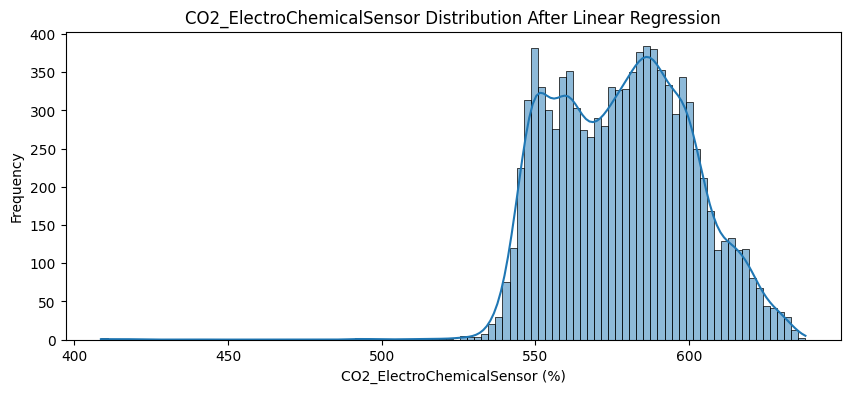

In [1908]:
plt.figure(figsize=(10, 4))
sns.histplot(df['CO2_ElectroChemicalSensor'], bins=100, kde=True)
plt.title("CO2_ElectroChemicalSensor Distribution After Linear Regression")
plt.xlabel("CO2_ElectroChemicalSensor (%)")
plt.ylabel("Frequency")
plt.show()

#### 3f. Metal Oxide Sensor columns

We have noted earlier that 'MetalOxideSensor_Unit3' has 2554 missing cells (25.9% of the dataset). This high level of missingness needs to be handled carefully. Imputation can introduce bias, and dropping rows causes a big dataset shrink. We first examine correlation between metal oxide sensor values and our target variable.

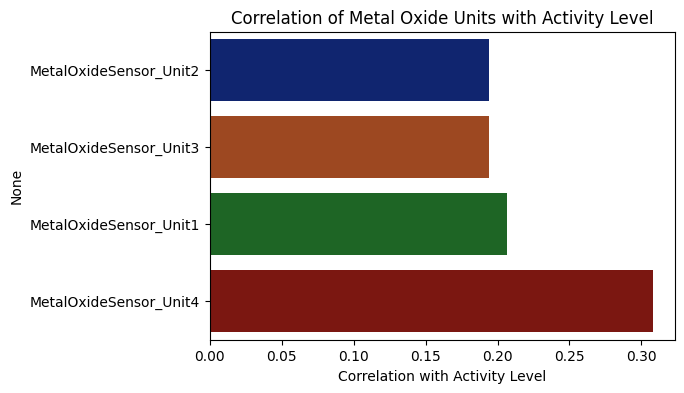

In [1909]:
#Conversion of activity level into it's numeric representation, preserving meaning
activity_mapping = {'low_activity': 0, 'moderate_activity': 1, 'high_activity': 2}
df['Activity Level'] = df['Activity Level'].map(activity_mapping)

target = 'Activity Level'
units = [
    'MetalOxideSensor_Unit1',
    'MetalOxideSensor_Unit2',
    'MetalOxideSensor_Unit3',
    'MetalOxideSensor_Unit4'
]

corrs = df[units + [target]].corr()[target].drop(target).sort_values()

plt.figure(figsize=(6,4))
sns.barplot(x=corrs.values, y=corrs.index, palette='dark')
plt.title('Correlation of Metal Oxide Units with Activity Level')
plt.xlabel('Correlation with Activity Level')
plt.show()

MetalOxideSensor_Unit4 shows the strongest correlation (~0.31) with Activity Level, making it the most relevant predictor among the four.
Units 1, 2, and 3 all have weaker and similar correlations (~0.19–0.20), suggesting limited predictive power.

#### Correlation between metal oxide units

We can plot a heatmap to examine the correlation between metal oxide units

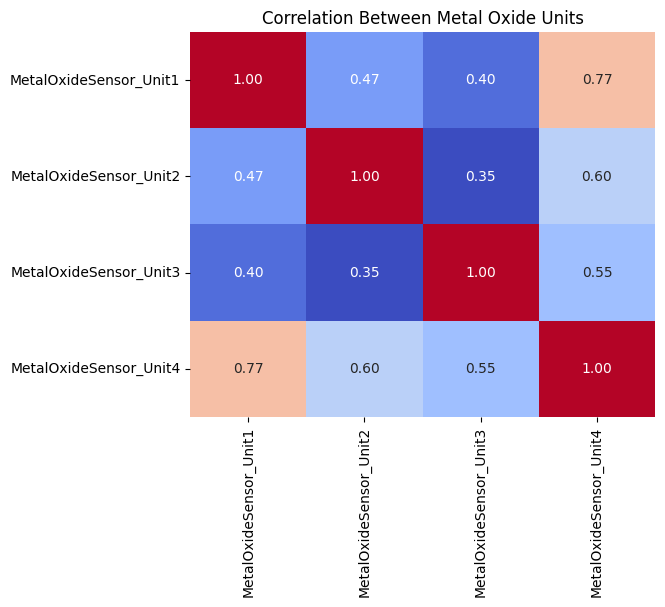

In [1910]:
plt.figure(figsize=(6,5))
sns.heatmap(df[units].corr(), annot=True, fmt=".2f", cmap='coolwarm', cbar=False)
plt.title('Correlation Between Metal Oxide Units')
plt.show()

MetalOxideSensor_Unit4 is strongly correlated with Unit1 (0.77) and moderately with Unit2 (0.60) and Unit3 (0.55), indicating shared information.

#### Readings by time of day

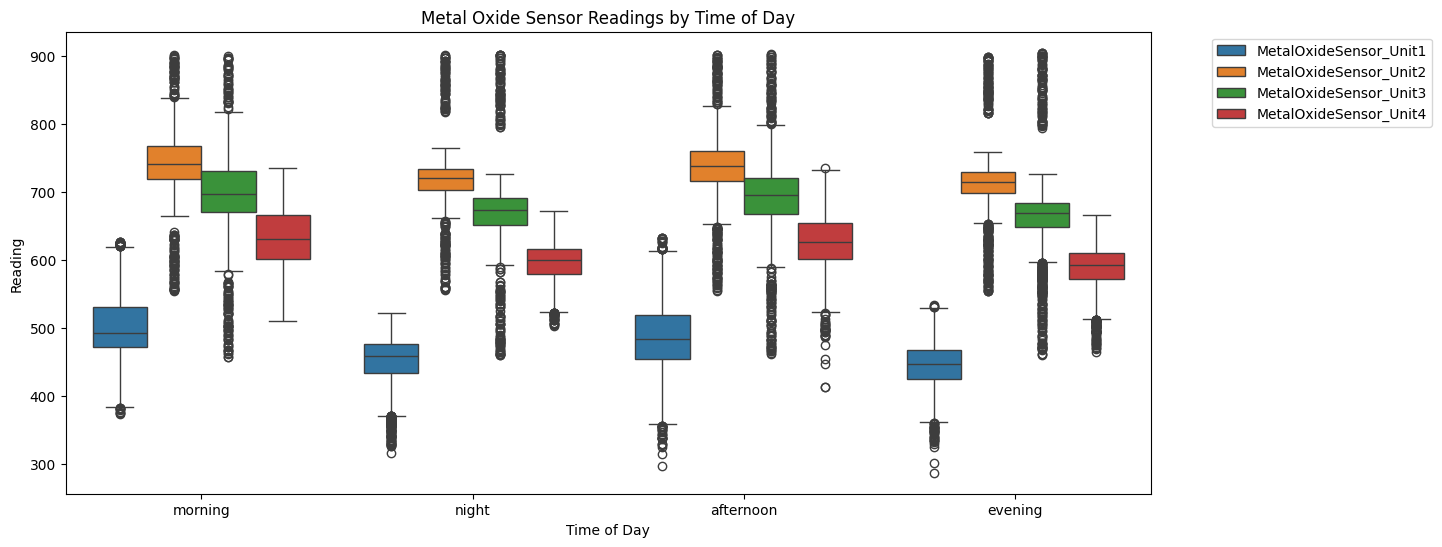

In [1911]:
melted = df.melt(id_vars=['Time of Day'], 
                 value_vars=[
                     'MetalOxideSensor_Unit1', 
                     'MetalOxideSensor_Unit2', 
                     'MetalOxideSensor_Unit3', 
                     'MetalOxideSensor_Unit4'
                 ],
                 var_name='Sensor Unit', value_name='Reading')

plt.figure(figsize=(14, 6))
sns.boxplot(x='Time of Day', y='Reading', hue='Sensor Unit', data=melted)
plt.title('Metal Oxide Sensor Readings by Time of Day')
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.show()



Metal oxide sensor readings show consistent, distinguishable patterns across different times of day, suggesting a time‑dependent relationship.

#### Outlier count

In [1912]:
metaloxide_cols = [
    'MetalOxideSensor_Unit1',
    'MetalOxideSensor_Unit2',
    'MetalOxideSensor_Unit3',
    'MetalOxideSensor_Unit4'
]

outlier_counts = {}

for col in metaloxide_cols:
    Q1 = df[col].quantile(0.25)
    Q3 = df[col].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    
    outliers = df[(df[col] < lower_bound) | (df[col] > upper_bound)]
    outlier_counts[col] = len(outliers)

outlier_summary = pd.DataFrame.from_dict(outlier_counts, orient='index', columns=['Outlier Count'])
outlier_summary['Outlier %'] = (outlier_summary['Outlier Count'] / len(df) * 100).round(2)

print(outlier_summary)

                        Outlier Count  Outlier %
MetalOxideSensor_Unit1            619       6.27
MetalOxideSensor_Unit2            672       6.80
MetalOxideSensor_Unit3            718       7.27
MetalOxideSensor_Unit4            298       3.02


#### Dropping 'MetalOxideSensor_Unit3' column from dataset

`Conclusion`: Unit 3 has the highest outlier rate (7.27%) and a very high missingness rate (25.9%), reducing usable data. Its correlation with activity level is similar to other units 1 and 2 but offers little unique information. It is also moderately correlated with other metal oxide units, making it more likely to add redundancy rather than predictive value. We will proceed to drop the 'MetalOxideSensor_Unit3' column from our dataset

In [1913]:
df = df.drop(columns=['MetalOxideSensor_Unit3'])

#### Handling outliers for remaining columns

The outlier values aren’t too far from the main cluster (no values in the millions or negative gas readings). They occur across multiple time-of-day categories, not in one strange isolated case, which suggests they could be real environmental variation or sensor drift rather than broken readings. They are also consistent across multiple metal oxide units, hence may be reflecting actual environmental changes. As such, We will keep them as they are

---
### 4. Categorical features data cleaning

#### 4a. 'Activity Level' column

In [1914]:
df["Activity Level"].value_counts()


Activity Level
0    5722
1    3082
2    1076
Name: count, dtype: int64

There is an imbalance present - low activity level dominates the dataset and high activity is relatively rare. This could affect our predicitive ML performance, so class balancing techniques might be needed later. 

The labels 'low_activity', 'moderate_activity' and 'high_activity' are ordinal in nature, and spaced regularly. We can convert these labels into numeric values to prepare for modelling, as we have done earlier in part 3f.

In [1915]:
print("Activity Level:",df['Activity Level'].unique())

Activity Level: [0 2 1]


Moving forward, we will work with this encodded version of Activity Level

#### 4b. 'Ambient Light Level' Column

- We know that there are 2519 missing cells in this column (25.19% of the dataset)

In [1916]:
full_data = df['Activity Level'].value_counts(normalize=True).rename('Full Data')
missing_a = df[df['Ambient Light Level'].isna()]
missing_proportions = missing_a['Activity Level'].value_counts(normalize=True).rename('Missing Ambient Light Level')

table = pd.concat([missing_proportions, full_data], axis=1) * 100
table = table.round(2)

print("\nActivity Level Distribution (%):\n")
print(table)


Activity Level Distribution (%):

                Missing Ambient Light Level  Full Data
Activity Level                                        
0                                     58.20      57.91
1                                     31.32      31.19
2                                     10.48      10.89


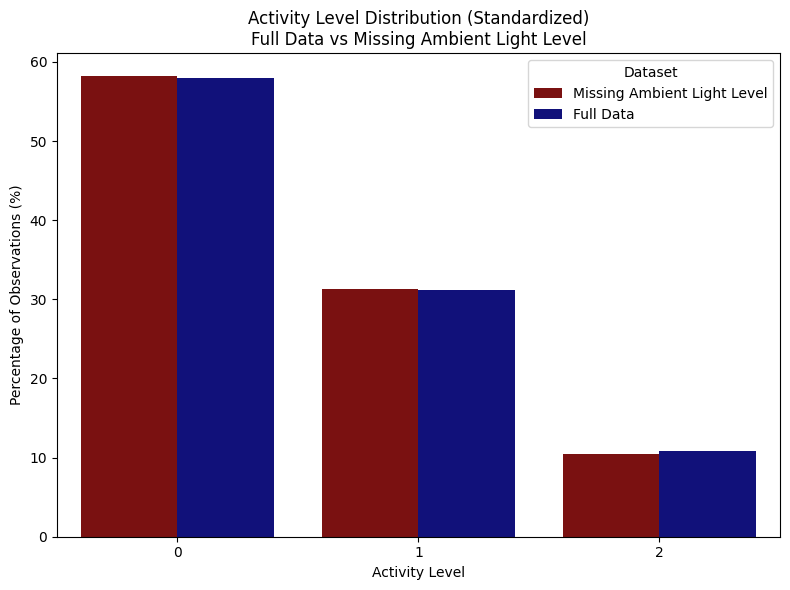

In [1917]:
table_reset = table.reset_index().melt(id_vars='Activity Level', 
                                       var_name='Dataset', 
                                       value_name='Percentage')
table_reset.rename(columns={'index': 'Activity Level'}, inplace=True)


plt.figure(figsize=(8, 6))
sns.barplot(data=table_reset, x='Activity Level', y='Percentage', hue='Dataset', palette=['darkred', 'darkblue'])
plt.ylabel("Percentage of Observations (%)")
plt.title("Activity Level Distribution (Standardized)\nFull Data vs Missing Ambient Light Level")
plt.legend(title="Dataset")
plt.tight_layout()
plt.show()

The distribution of activity levels in the full dataset and among rows with missing 'Ambient Light Level' values shows less than a 0.5 percentage point difference across all classes. This suggests that the missingness in this column is not correlated with the target (Activity Level), and therefore likely not a predictive signal. 

#### Missingness count against Time of Day

In [1918]:
df.groupby("Time of Day")["Ambient Light Level"].apply(lambda x: x.isna().sum())

Time of Day
afternoon    668
evening      671
morning      603
night        577
Name: Ambient Light Level, dtype: int64

The missingness of Ambient Light Level readings occur at all time of day, ruling out the possibility of a scheduled downtime. 

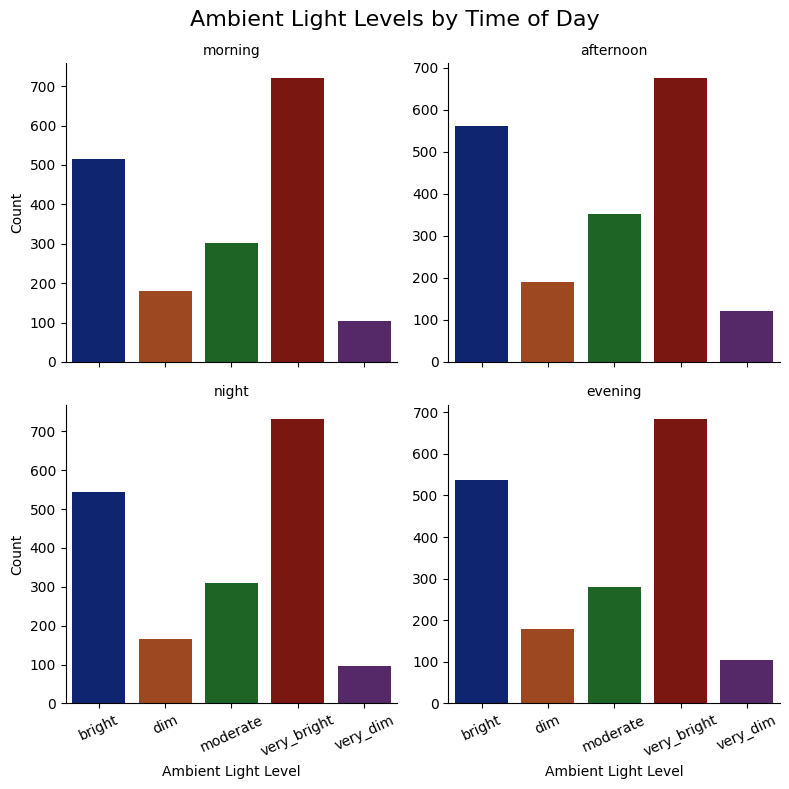

In [1919]:
#Plotting Ambient Light Levels in different time of day
co_plot_df = df.dropna(subset=['Ambient Light Level', 'Time of Day'])
g = sns.FacetGrid(co_plot_df, col='Time of Day', col_wrap=2, height=4, sharey=False)
g.map(sns.countplot, 'Ambient Light Level', order=sorted(co_plot_df['Ambient Light Level'].unique()), palette='dark')
g.set_axis_labels("Ambient Light Level", "Count")
g.set_titles(col_template="{col_name}")
g.fig.subplots_adjust(top=0.85)
g.fig.suptitle("Ambient Light Levels by Time of Day", fontsize=16)

for ax in g.axes.flat:
    for label in ax.get_xticklabels():
        label.set_rotation(25)

plt.tight_layout()
plt.show()

We can see that the distribution of 'Ambient Light Levels' is relatively unchanged throughout the day, meaning these levels are not affected by the natural lighting outside. 'very_bright' is the clear and dominant mode across all time slices (as the chart suggests). We will impute this value for the missing columns.

In [1920]:
# Fill missing values with the mode 'very_bright'
df['Ambient Light Level'] = df['Ambient Light Level'].fillna('very_bright')

print("Ambient Light Level:",df['Ambient Light Level'].unique())

Ambient Light Level: ['very_dim' 'bright' 'very_bright' 'moderate' 'dim']


4c. 'CO_GasSensor' column

We know from earlier that there are 1365 missing entries in this column (13.8% of dataset)

In [1921]:
full_data = df['Activity Level'].value_counts(normalize=True).rename('Full Data %')

missing_co = df[df['CO_GasSensor'].isna()]
missing_proportions = missing_co['Activity Level'].value_counts(normalize=True).rename('Missing CO_GasSensor %')

table = pd.concat([missing_proportions, full_data], axis=1)
table = table * 100  
table = table.round(2) 

print(table)


                Missing CO_GasSensor %  Full Data %
Activity Level                                     
0                                59.71        57.91
1                                29.89        31.19
2                                10.40        10.89


The distribution of activity levels in the full dataset and among rows with missing CO_GasSensor values shows less than a 2 percentage point difference across all classes. This suggests that the missingness in this column is not correlated with the target (Activity Level), and therefore likely not a predictive signal. This means that we can safely impute these missing cells

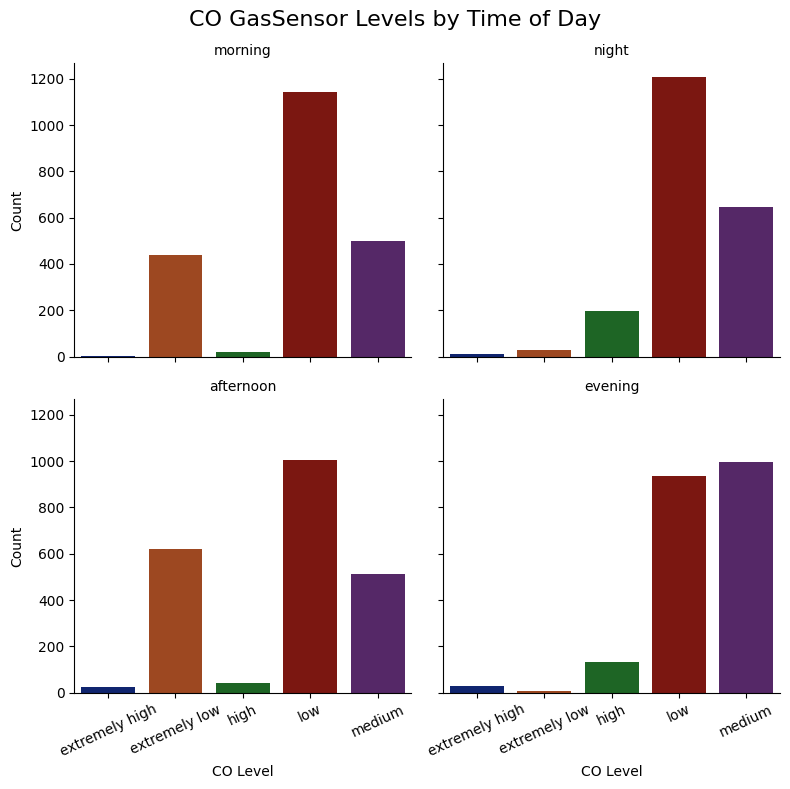

In [1922]:
#Plotting CO_Levels (excluding missing cells) in different time of day 

co_plot_df = df.dropna(subset=['CO_GasSensor', 'Time of Day'])
g = sns.FacetGrid(co_plot_df, col='Time of Day', col_wrap=2, height=4, sharey=True)
g.map(sns.countplot, 'CO_GasSensor', order=sorted(co_plot_df['CO_GasSensor'].unique()), palette='dark')
g.set_axis_labels("CO Level", "Count")
g.set_titles(col_template="{col_name}")
g.fig.subplots_adjust(top=0.85)
g.fig.suptitle("CO GasSensor Levels by Time of Day", fontsize=16)

for ax in g.axes.flat:
    for label in ax.get_xticklabels():
        label.set_rotation(25)

plt.tight_layout()
plt.show()

We can see that for morning, afternoon and night,'low' is the modal CO level. In the evening, 'medium' is the modal CO level. Because CO levels vary by time of day and the missingness isn’t correlated with the target, we impute missing values using the most frequent CO level per time segment as opposed to using a single global mode

In [1923]:
#Imputation based on time of day
time_mode_map = df.groupby('Time of Day')['CO_GasSensor'].agg(lambda x: x.mode().iloc[0])

def impute_co(row):
    if pd.isna(row['CO_GasSensor']):
        return time_mode_map[row['Time of Day']]
    return row['CO_GasSensor']

df['CO_GasSensor'] = df.apply(impute_co, axis=1)


All the missing cells in the 'CO_GasSensor' column are now filled with the modal CO level corresponding to their time of day.

In [1924]:
print("CO_GasSensor:",df['CO_GasSensor'].unique())

CO_GasSensor: ['medium' 'low' 'extremely low' 'high' 'extremely high']


The labels 'extremely low', 'low', 'medium', 'high' and 'extremely high' are ordinal in nature, and spaced regularly. We can therefore convert these labels into numeric values (encodding). This transformation preserves the order and and makes the data suitable for machine learning models, which requires numeric inputs.

In [1925]:
co_levels = {
    
    'extremely low': 1,
    'low': 2,
    'medium': 3,
    'high': 4,
    'extremely high': 5
}

df['CO_GasSensor'] = df['CO_GasSensor'].map(co_levels)


In [1926]:
print("CO_GasSensor: ", df['CO_GasSensor'].unique())


CO_GasSensor:  [3 2 1 4 5]


---

### 5. Bivariate analysis


Numerical Features


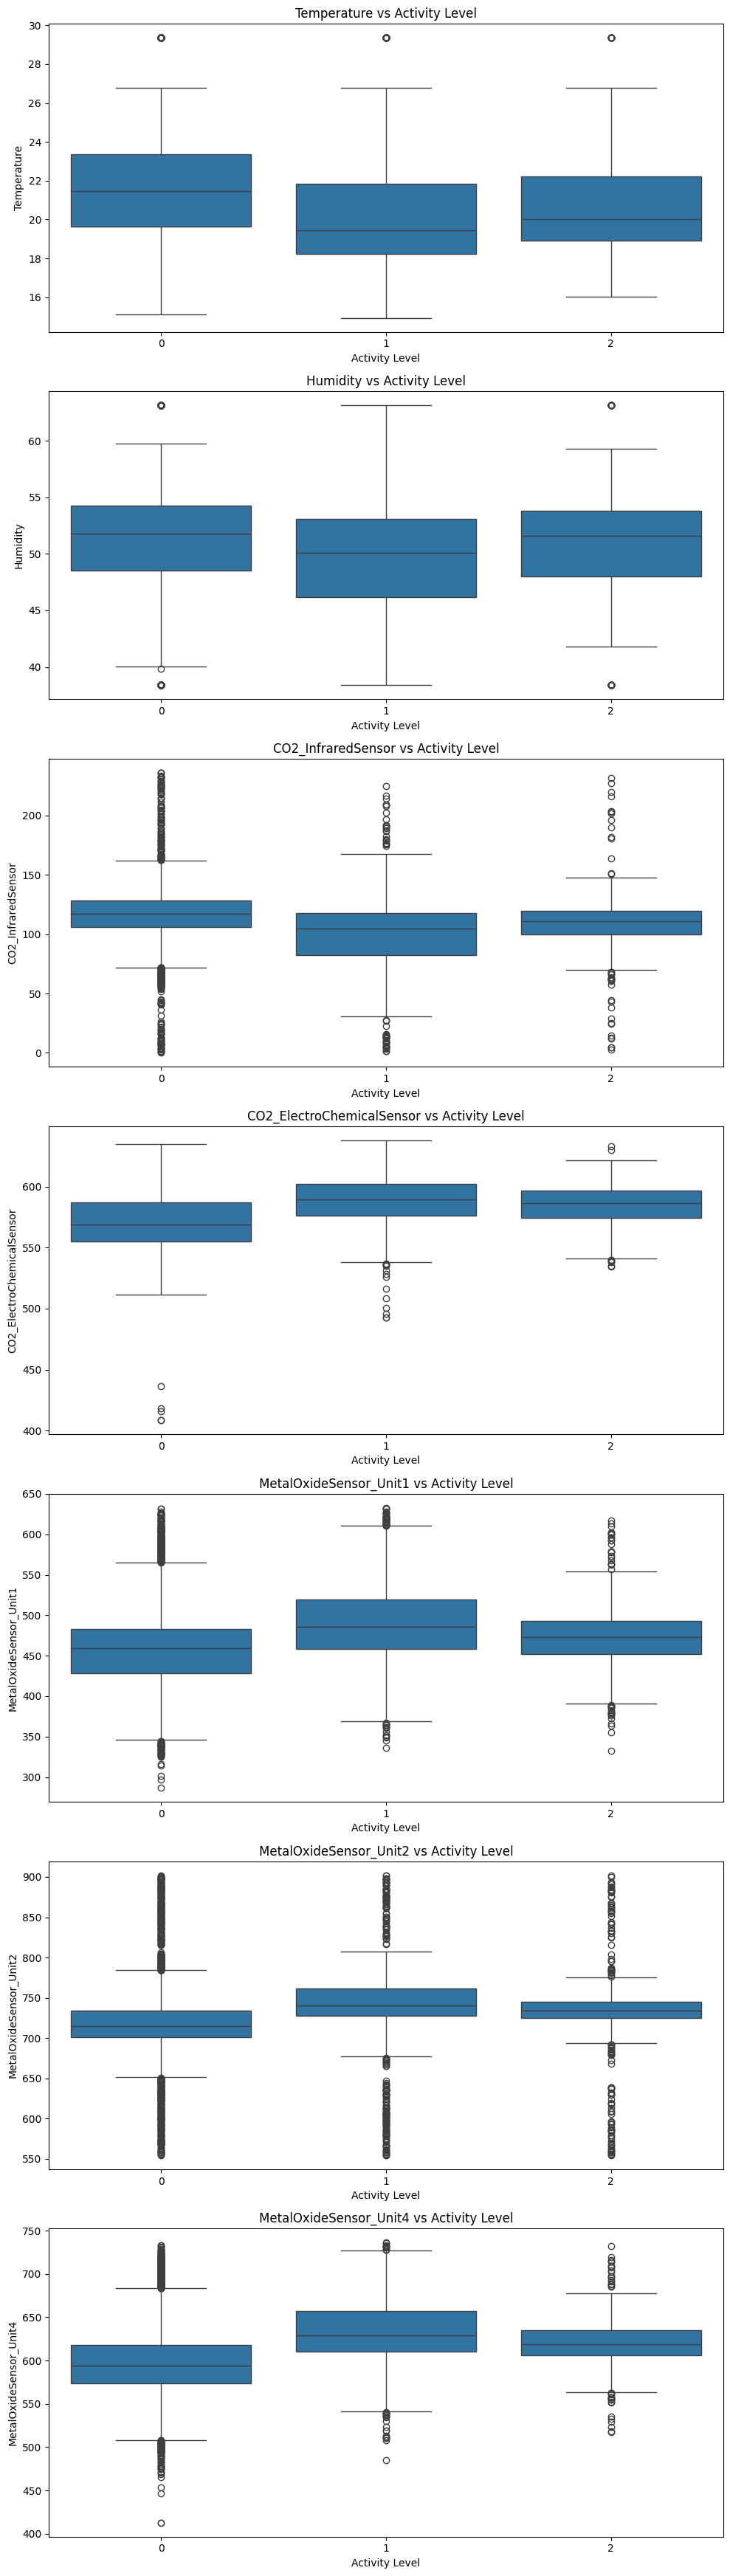

In [1927]:
numeric_cols = df.select_dtypes(include=['float64', 'int64']).columns.tolist()

numeric_cols.remove('CO_GasSensor')
numeric_cols.remove('Activity Level')

print("\nNumerical Features")
fig, axes = plt.subplots(nrows=len(numeric_cols), ncols=1, figsize=(10, 5 * len(numeric_cols)))
for i, col in enumerate(numeric_cols):
    sns.boxplot(x='Activity Level', y=col, data=df, ax=axes[i])
    axes[i].set_title(f"{col} vs Activity Level")
    axes[i].set_xlabel("Activity Level")
    axes[i].set_ylabel(col)
plt.tight_layout()
plt.show()


Overall Patterns from Numerical Features
- Most predictive features appear to be Metal Oxide Sensors and CO₂ Electrochemical Sensor.
- Temperature has weak-moderate predictive value, humidity is weak.
- Patterns suggest indoor air quality measures correlate strongly with activity level.


 Categorical Features


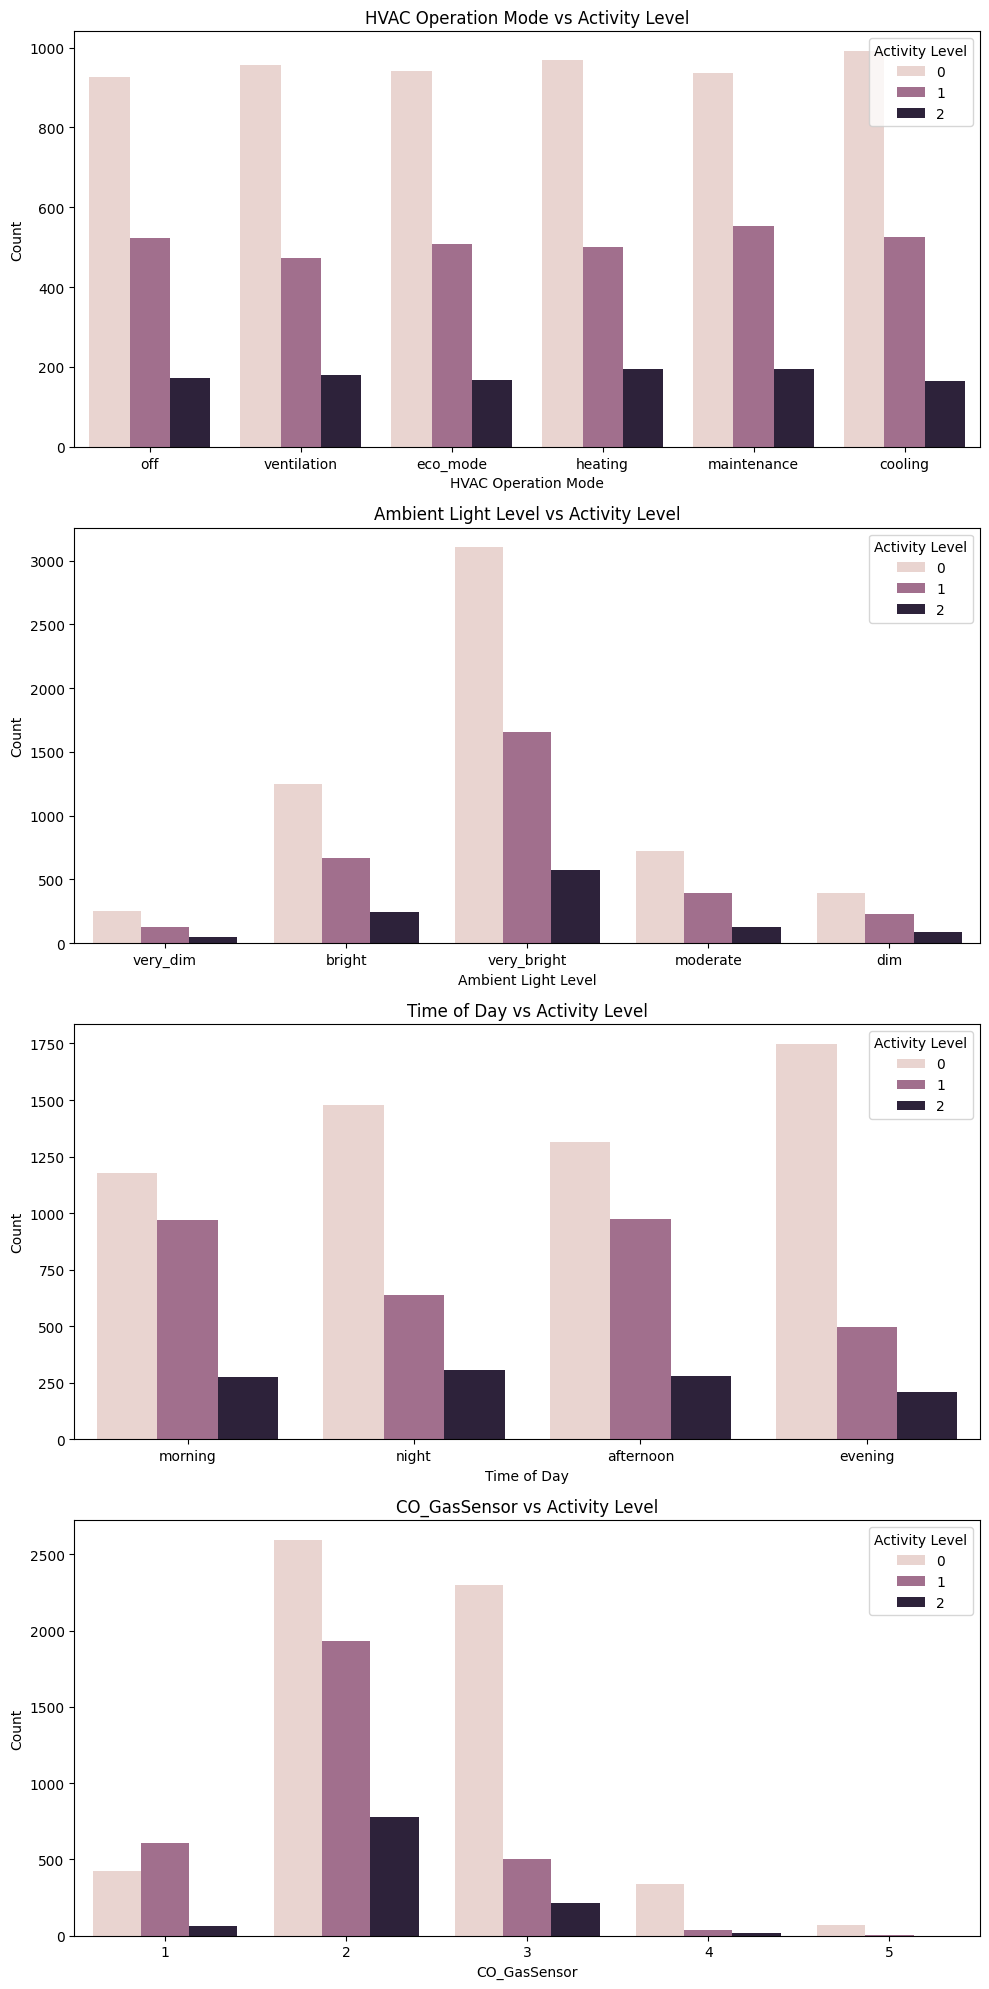

In [1928]:
print("\n Categorical Features")
cat_cols = ['HVAC Operation Mode', 'Ambient Light Level', 'Time of Day', 'CO_GasSensor']
fig, axes = plt.subplots(nrows=len(cat_cols), ncols=1, figsize=(10, 5 * len(cat_cols)))
for i, col in enumerate(cat_cols):
    sns.countplot(x=col, hue='Activity Level', data=df, ax=axes[i])
    axes[i].set_title(f"{col} vs Activity Level")
    axes[i].set_xlabel(col)
    axes[i].set_ylabel("Count")
    axes[i].tick_params(axis='x', rotation=0)
plt.tight_layout()
plt.show()

Overall Patterns from Categorical Features

- Ambient Light Level and Time of Day appear more useful than HVAC mode for predicting activity.
- CO_GasSensor shows some variation but might require encoding & combining with other features.
- Likely better predictive power when used in combination with strong numerical features (Metal Oxide & CO₂ readings).

---

### 6. Feature engineering